In [2]:
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import statistics as st
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.distributions.empirical_distribution import ECDF
from TimeSerie_fct import create_monthly_avg_time_serie
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf
from sklearn.utils import resample
import os


data_temperature = pd.read_table('../data/observatoire-geneve/TG_STAID000241.txt',sep = ',',
                                names = ['SOUID','DATE','TG','Q_TG'], skiprows = range(0,20))

data_temperature.drop(data_temperature[ data_temperature['Q_TG'] == 9 ].index, inplace = True)
data_temperature['Year'] = [int(str(d)[:4]) for d in data_temperature.DATE]
data_temperature['Month'] = [int(str(d)[4:6]) for d in data_temperature.DATE]
data_temperature['Day'] = [int(str(d)[6:8]) for d in data_temperature.DATE]

#Compute the day of the year for each year
day_of_year = np.array(len(data_temperature['Day']))

adate = [datetime.strptime(str(date),"%Y%m%d") for date in data_temperature.DATE]
data_temperature['Day_of_year'] = [d.timetuple().tm_yday for d in adate]
data_temperature.TG = data_temperature.TG/10.

In [3]:
df = data_temperature.copy()
plt.style.use("ggplot")

In [4]:
# Transformation en moyenne annuelle
Years = df.Year.unique()
data_Y = pd.DataFrame(np.array([[df[df.Year == y].TG.mean(),
                        df[df.Year == y].TG.median(),df[df.Year == y].TG.std(),y] for y in Years]),
                     index = (np.arange(np.shape(Years)[0])), columns=["Mean","Median","Std","Years"])
#Rupture de la moyenne en 1962

In [5]:
# QQ-plot of the annual mean
fig = qqplot(data_Y.Mean,loc = data_Y.Mean.mean(), scale = data_Y.Mean.std(), line ='45')
fig.suptitle("QQ-plot",y = 0.95,size='xx-large',weight = 'roman')
#plt.show()

plt.savefig("figure/Annual_qqplot.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [6]:
ecdf = ECDF(data_Y.Mean)
mean = data_Y.Mean.mean()
x = np.linspace(-4.+mean,4.+mean,5000)

fig, axs = plt.subplots(1,2, figsize=(14,4))

std = data_Y.Mean.std()
axs[0].plot(x,ecdf(x),"k",label='ecdf')
axs[0].plot(x,sc.stats.norm.cdf(x,loc = data_Y.Mean.mean(),scale = std), "b--", label = 'cdf')
axs[1].plot(x,np.abs(ecdf(x)-sc.stats.norm.cdf(x,loc = data_Y.Mean.mean() ,scale = std)),color = 'k')

axs[0].set(xlabel="x",ylabel="P (X<=x)")
axs[1].set(xlabel="x",ylabel="Absolute deviation")
axs[0].set_title("Ecdf vs cdf")
axs[1].set_title("Absolute deviation of the ecdf from the cdf")

axs[0].legend(loc = (0.05,0.8))

plt.savefig("figure/Annual_ecdf_cdf.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [7]:
fig, axs = plt.subplots(3, figsize=(10,8))

axs[0].plot(Years,data_Y.Mean, color = 'k')
axs[0].set_title("Annual mean temperature from 1901 to 2021")
axs[1].plot(Years,data_Y.Median, color = 'k')
axs[1].set_title("Annual median temperature from 1901 to 2021")
axs[2].plot(Years,data_Y.Std, color = 'k')
axs[2].set_title("Annual standard deviation of temperature from 1901 to 2021")
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
axs[0].set(xlabel="Years",ylabel="Temperature (°C)")
axs[1].set(xlabel="Years",ylabel="Temperature (°C)")
axs[2].set(xlabel="Years",ylabel="Standard deviation(°C)")

plt.savefig("figure/Annual_mean_median_std.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [8]:
#Calcul des anomalies normalisées

mean = data_Y.Mean.mean()
data_Y["anomalie_norm"] = (data_Y.Mean-mean)/(data_Y.Mean-mean).std()

mean1 = data_Y[data_Y.Years<=1962].Mean.mean()
mean2 = data_Y[data_Y.Years>1962].Mean.mean()
anom1 = (data_Y[data_Y.Years<=1962].Mean-mean1)/(data_Y[data_Y.Years<=1962].Mean-mean1).std()
anom2 = (data_Y[data_Y.Years>1962].Mean-mean2)/(data_Y[data_Y.Years>1962].Mean-mean2).std()

In [9]:
fig, axs = plt.subplots(3, figsize=(10,6))

fig.suptitle("Annual standardized temperature anomalies :",y = 1.1,size='x-large',weight = 'roman')

axs[0].bar(Years,data_Y.anomalie_norm, color='k')
axs[0].set_title("Over the period 1901-2021")
axs[1].bar(Years[Years<=1962],anom1, color = 'k')
axs[1].set_title("Over the period 1901-1962")
axs[2].bar(Years[Years>1962],anom2, color = 'k')
axs[2].set_title("Over the period 1963-2021")

axs[0].set(xlabel="Years")
axs[1].set(xlabel="Years")
axs[2].set(xlabel="Years")

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.6)

plt.savefig("figure/Annual_anomalie_temperature.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [10]:
#Stationarity test on annual mean with addfuller
test_addfuller = adfuller(data_Y.Mean, maxlag=None, regression='nc', autolag='AIC'
                          , store=False, regresults=False)

g = open('txt/addfullerTest_annual.txt','w')
g.write("Annual mean (no constant) : p-value = "+str(test_addfuller[1])+'\n')
g.close()

#Stationarity test on annual mean with addfuller
test_addfuller = adfuller(data_Y.Mean, maxlag=None, regression='ct', autolag='AIC'
                          , store=False, regresults=False)

g = open('txt/addfullerTest_annual.txt','a')
g.write("Annual mean (constant + trend) : p-value = "+str(test_addfuller[1])+'\n')
g.close()

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 300)

fig.suptitle("ACF and PACF of annual mean temperature",y = 1.1,size='x-large',weight = 'roman')

plot_acf(data_Y.Mean, lags=50,ax=axes[0], color='k',zero = False)
plot_pacf(data_Y.Mean, lags=50,ax=axes[1], color='k',zero = False)

axes[0].set(xlabel="lags")
axes[1].set(xlabel="lags")

plt.savefig("figure/Annual_acf_pacf.png", dpi=300, bbox_inches='tight')
plt.close(fig)

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


In [12]:
#Test U de Mann-Whitney
# Null hypothesis is that X and Y the probability of X being 
# greater than Y is equal to the probability of Y being greater than X.

p_values = np.array([])

for i in range(1,np.shape(data_Y.Mean)[0]-1):
    x = data_Y.Mean[:i]
    y = data_Y.Mean[i:]
    p = np.array([sc.stats.mannwhitneyu(x, y, use_continuity=True, alternative='two-sided').pvalue])
    # p = np.array([sc.stats.kendalltau(x, y).pvalue])
    p_values = np.concatenate([p_values,p])

alpha = 0.05

fig = plt.figure(figsize=(8,4), dpi=300, tight_layout = True)
fig.suptitle("P-values of the Mann-Whitney U test",y = 1.,size='x-large',weight = 'roman')

for i in range(1,np.shape(data_Y.Mean)[0]-1):
    if (p_values[i-1]>alpha):
        line1, = plt.plot(i,p_values[i-1],'o',color='red',label = 'p-value > '+str(alpha))
    else:
        line2, =plt.plot(i,p_values[i-1],'o',color='grey',label='p-value <= '+str(alpha))

        plt.axhline(y=0.05,linestyle='--',label='p_value = '+str(alpha))

fig.legend([line1,line2],['p-value > '+str(alpha),'p-value <= '+str(alpha)],loc = (0.775,0.73))
plt.xlabel('Size of \'left\' sample in the U test')
plt.ylabel('p-values')

plt.savefig("figure/p_values_MannWhitneyTest.png", dpi=300, bbox_inches='tight')
plt.close(fig)

# We can easily reject the null hypothesis at a level of 0.05 (or smaller)

In [13]:
#Test Q de Ljung-Box

test_Q = sm.stats.acorr_ljungbox(data_Y.Mean, lags=range(1,50), return_df=True,boxpierce=True)

p_values_McLeod_Li = sm.stats.acorr_ljungbox(data_Y.Mean**2, lags=range(1,50), return_df=True).lb_pvalue
p_values_Pierce = test_Q.lb_pvalue
p_values_Ljung = test_Q.bp_pvalue

fig = plt.figure(figsize=(8,4), dpi=300, tight_layout = True)
fig.suptitle("P-values of the Ljung-Box ,Box-Pierce test and McLeod-Li",y = 0.95
             ,size='x-large',weight = 'roman')


plt.plot(p_values_Pierce,'o-',markersize = 4,label='Box-Pierce')
plt.plot(p_values_Ljung,'-o',markersize = 4,label='Ljung-Box')
plt.plot(p_values_McLeod_Li,'-o',markersize = 4,label='McLeod-Li')
plt.semilogy()

fig.legend(loc = (0.82,0.7))
plt.xlabel('Autocorrelation lags')
plt.ylabel('p-values')

plt.savefig("figure/p_values_Ljung_Pierce_McLeod.png", dpi=300, bbox_inches='tight')
plt.close(fig)

# Definition generic function for plots

In [14]:
def plot_ljung_pierce(data, loca = (0.82,0.7), semilog_y = True,fname ='figure/p_values_Ljung_Pierce_McLeod_test.png', closefig = False,alpha = 0.05,df=0):
    test_Q = sm.stats.acorr_ljungbox(data, lags=range(1,50), return_df=True,boxpierce=True,model_df = df)

    p_values_McLeod_Li = sm.stats.acorr_ljungbox(data**2, lags=range(1,50), return_df=True,model_df = df).lb_pvalue
    p_values_Pierce = test_Q.lb_pvalue
    p_values_Ljung = test_Q.bp_pvalue
    
    fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
    fig.suptitle("P-values of the Ljung-Box ,Box-Pierce and McLeod-Li Tests",y = 0.95
                 ,size='x-large',weight = 'roman')


    plt.plot(p_values_Pierce,'o-',markersize = 4,label='Box-Pierce')
    plt.plot(p_values_Ljung,'-o',markersize = 4,label='Ljung-Box')
    plt.plot(p_values_McLeod_Li,'-o',markersize = 4,label='McLeod-Li')
    
    if (semilog_y): plt.semilogy()
    plt.axhline(y=alpha,linestyle='--',label='p_value = '+str(alpha))
    fig.legend(loc = loca)
    plt.xlabel('Autocorrelation lags')
    plt.ylabel('p-values')

    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig) : plt.close(fig)
    return 

In [15]:
def plot_acf_pacf(data,lag = 50,closefig=False,fname = "figure/Annual_acf_pacf_test.png",title = 'ACF and PACF'):
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 300)
    
    fig.suptitle(title,y = 1.1,size='x-large',weight = 'roman')
    
    plot_acf(data, lags=lag,ax=axes[0], color='k',zero = False)
    plot_pacf(data, lags=lag,ax=axes[1], color='k',zero = False,method='ywm')
    
    axes[0].set(xlabel="lags")
    axes[1].set(xlabel="lags")
    
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig): plt.close(fig)
    return

In [16]:
def plot_test_U_MannWhitney(data,alt = 'two-sided',alpha = 0.05, lag = 1,loca = (0.775,0.73),fname="figure/p_values_MannWhitneyTest_test.png",closefig=False):
    p_values = np.array([])
        
    for i in range(lag,np.shape(data)[0]-lag):
        x = data[:i]
        y = data[i:]
        p = np.array([sc.stats.mannwhitneyu(x, y, use_continuity=True, alternative=alt).pvalue])
        p_values = np.concatenate([p_values,p])

    
    fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
    fig.suptitle("P-values of the Mann-Whitney U test",y = 1.,size='x-large',weight = 'roman')
    
    line1, =plt.plot([],'o',color='red',label='p-value > '+str(alpha))
    line2, =plt.plot([],'o',color='grey',label='p-value <= '+str(alpha))
    
    for i in range(lag,np.shape(data)[0]-lag):
        if (p_values[i-1]>alpha):
            line1, = plt.plot(i,p_values[i-1],'o',color='red',label = 'p-value > '+str(alpha))
        else:
            line2, =plt.plot(i,p_values[i-1],'o',color='grey',label='p-value <= '+str(alpha))
    
        plt.axhline(y=alpha,linestyle='--',label='p_value = '+str(alpha))

    fig.legend([line1,line2],['p-value > '+str(alpha),'p-value <= '+str(alpha)],loc = loca)
    plt.xlabel('Size of \'left\' sample in the U test')
    plt.ylabel('p-values')
   # plt.yaxis.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]) 
    plt.gca().yaxis.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], minor = True)
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig): plt.close(fig)
    
    return

In [17]:
def qq_plot(data,fname = "figure/Annual_qqplot_test.png"):
    fig = qqplot(data,loc = data.mean(), scale = data.std(), line ='45')
    fig.suptitle("QQ-plot",y = 0.95,size='xx-large',weight = 'roman')
    plt.show()
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close(fig)
    return

In [18]:
def ecdf_vs_cdf(data,fname ="figure/Annual_ecdf_cdf_test.png", closefig=False):
    ecdf = ECDF(data)
    mean = data.mean()
    std = data.std()
    x = np.linspace(-4.+mean,4.+mean,5000)
    
    fig, axs = plt.subplots(1,2, figsize=(14,4))
    
    axs[0].plot(x,ecdf(x),"k",label='ecdf')
    axs[0].plot(x,sc.stats.norm.cdf(x,loc = mean,scale = std), "b--", label = 'cdf')
    axs[1].plot(x,np.abs(ecdf(x)-sc.stats.norm.cdf(x,loc = mean ,scale = std)),color = 'k')
    
    axs[0].set(xlabel="x",ylabel="P (X<=x)")
    axs[1].set(xlabel="x",ylabel="Absolute deviation")
    axs[0].set_title("Ecdf vs cdf")
    axs[1].set_title("Absolute deviation of the ecdf from the cdf")
    
    axs[0].legend(loc = (0.05,0.8))
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig): plt.close(fig)
    return

# Model Identification and Selection

In [19]:
break_year = 1962


mean1 = data_Y.Mean[data_Y.Years<break_year].mean()
data1 = data_Y[data_Y.Years<break_year].copy()

mean2 = data_Y.Mean[data_Y.Years>=break_year].mean()
data2 = data_Y[data_Y.Years>=break_year].copy()

n = np.shape(data_Y.Mean)[0]
t = np.array(data_Y.Years).reshape((n,1))
one = np.ones(shape=(np.shape(t)[0],1))
X = np.concatenate([one,t],axis = 1)

n1 = np.shape(data1.Mean)[0]
n2 = np.shape(data2.Mean)[0]
t1 = np.array(data1.Years).reshape((n1,1))
t2 = np.array(data2.Years).reshape((n2,1))
one1 = np.ones(shape=(np.shape(t1)[0],1))
X1 = np.concatenate([one1,t1],axis = 1)
one2 = np.ones(shape=(np.shape(t2)[0],1))
X2 = np.concatenate([one2,t2],axis = 1)

acf1 = acf(data1.Mean,nlags=np.shape(data1.Mean)[0],fft=False)
sigma1 = data1.Mean.var()*sc.linalg.toeplitz(acf1)
GLS_reg1 = sm.GLS(data1.Mean,X1,sigma1).fit()

acf2 = acf(data2.Mean,nlags=np.shape(data2.Mean)[0],fft=False)
sigma2 = data2.Mean.var()*sc.linalg.toeplitz(acf2)
GLS_reg2 = sm.GLS(data2.Mean,X2,sigma2).fit()

acf_ = acf(data_Y.Mean,nlags=np.shape(data_Y.Mean)[0],fft=False)
sigma_ = data_Y.Mean.var()*sc.linalg.toeplitz(acf_)
GLS_reg = sm.GLS(data_Y.Mean,X,sigma_).fit()

coef1 = GLS_reg1.params
coef2 = GLS_reg2.params
coef = GLS_reg.params

f = lambda x: coef[0]+coef[1]*x
f1 = lambda x: coef1[0]+coef1[1]*x
f2 = lambda x: coef2[0]+coef2[1]*x
f_split = lambda x: (x<break_year)*f1(x)+(x>=break_year)*f2(x)

In [20]:
#On sauvegarde les summary pour les deux régréssion
summa1 = GLS_reg1.summary()
summa2 = GLS_reg2.summary()
summa = GLS_reg.summary()
print()
# Holm-Bonferroni's Procedure avec alpha = 0.1 pour joindre les deux tests 

g = open('txt/summary1901-1962_GLS.txt','w')
g.write(summa1.as_latex())
g.close()
g = open('txt/summary1962-2021_GLS.txt','w')
g.write(summa2.as_latex())
g.close()
g = open('txt/summary_GLS.txt','w')
g.write(summa.as_latex())
g.close()

In [21]:
#Plot split-regression
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Modelisation of the trend by GLS on two succesive period",y = 0.95,size='x-large',weight = 'roman')

plt.plot(data1.Years,f_split(data1.Years),'r',label='1901-1961 GLS fit')
plt.plot(data2.Years,f_split(data2.Years),'b',label='1962-2021 GLS fit')
plt.plot(data_Y.Years,data_Y.Mean,'grey')

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
fig.legend(['1901-1961 GLS fit','1962-2021 GLS fit'],loc = (0.11,0.8))

plt.savefig('figure/GLS_split_period', dpi=300, bbox_inches='tight')
plt.close()

In [22]:
#Plot entiere regression
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Modelisation of the trend by GLS",y = 0.95,size='x-large',weight = 'roman')

plt.plot(Years,f(Years),label = '1901-2021 GLS fit')
plt.plot(data_Y.Years,data_Y.Mean,'grey')

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
fig.legend(['1901-2021 GLS fit'],loc = (0.11,0.84))

plt.savefig('figure/GLS_full_period', dpi=300, bbox_inches='tight')
plt.close()

In [23]:
#On fixe la tendance comme étant la tendance calculé sur deux période
data_Y["Mean_detrended"] = data_Y.Mean-f_split(Years)

In [24]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Detrended mean temperature",y = 1,size='x-large',weight = 'roman')

plt.plot(data_Y.Mean_detrended,'grey')

plt.xlabel('Years')
plt.ylabel('Temeprature (°C)')

plt.savefig('figure/detrended_mean_temperature', dpi=300, bbox_inches='tight')
plt.close()

In [25]:
plot_ljung_pierce(data_Y.Mean_detrended,semilog_y = False,loca = (0.78,0.66),closefig=True
                 ,fname = 'figure/Detrended_mean_Ljung_Pierce.png')
plot_acf_pacf(data_Y.Mean_detrended,lag=50, title = 'ACF and PACF of annual detrended mean temperature'
              ,closefig=True,fname = 'figure/Detrended_mean_acf_pacf.png')

In [26]:
#Stationarity test on detrended mean with addfuller
test_addfuller = adfuller(data_Y.Mean_detrended, maxlag=None, regression='nc', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/addfullerTest_annual.txt','a')
g.write("Annual detrended mean (no constant) : p-value = "+str(test_addfuller[1])+'\n')
g.close()

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [27]:
#Model selection using AIC
p = np.array(np.arange(0,4))
q = np.array(np.arange(0,10))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

AIC = np.zeros(shape=(np.shape(param)[0],))

model_selection = pd.DataFrame(np.array([param[:,0],param[:,1],AIC]).T, columns = ["param_p","param_q","AIC"])

for i, (pp,qq) in enumerate(param):
    arma_mod = ARIMA(data_Y.Mean_detrended, order=(pp,0,qq)).fit(method = 'innovations_mle')
    model_selection.AIC[i] = arma_mod.aic

i = np.argmin(model_selection.AIC)
mod = model_selection.to_latex()

g = open('txt/ModelSelection_annual.txt','w')
g.write(mod)
g.close()

In [28]:
print(i)

2


In [29]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the detrended mean",y = 1,size='x-large',weight = 'roman')

plt.plot(range(0,10),model_selection[model_selection.param_p == 0].AIC,'o-')
plt.plot(range(0,10),model_selection[model_selection.param_p == 1].AIC,'-o')
plt.plot(range(0,10),model_selection[model_selection.param_p == 2].AIC,'o-')
plt.plot(range(0,10),model_selection[model_selection.param_p == 3].AIC,'-o')

plt.xlabel('MA(q) parameters')
plt.ylabel('AIC')
qq = ['q=0','q=1','q=2','q=3','q=4','q=5','q=6','q=7','q=8','q=9']
plt.xticks(range(0,10),qq)
fig.legend(['p=0','p=1','p=2','p=3'],loc = (0.10,0.67))

plt.savefig('figure/detrended_mean_model_selection_AIC', dpi=300, bbox_inches='tight')
plt.close()

In [30]:
#We choose the model ARMA(0,2) with the AIC
p = 0
q = 2

arma_mod = ARIMA(data_Y.Mean_detrended, order=(p,0,q)).fit(method='innovations_mle')
res = arma_mod.resid 

In [31]:
summary = arma_mod.summary()

g = open('txt/ModelSelection_annual.txt','w')
g.write(summary.as_latex())
g.close()

In [32]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Residus of the ARMA(0,2) model",y = 0.97,size='x-large',weight = 'roman')

plt.plot(Years,res,'grey')

plt.xlabel('Years')
plt.ylabel('Temperature (°C)')

plt.savefig('figure/detrended_mean_residu', dpi=300, bbox_inches='tight')
plt.close()

In [33]:
plot_ljung_pierce(res,semilog_y = False,loca = (0.78,0.66),df = p+q,closefig=True,fname='figure/LjungBox_Pierce_residu')
norm_test = arma_mod.test_normality(method='jarquebera')
hetero_test = arma_mod.test_heteroskedasticity(method='breakvar')

g = open('txt/Annual_resid_normalityCheck.txt','w')
g.write('Normality test : p-value = '+str(norm_test[0,1])+'\n'+'Heteroskedasticity test : p-value = '+str(hetero_test[0,1]))
g.close()

In [34]:
plot_test_U_MannWhitney(res,alt = 'two-sided',loca = (0.085,0.73),closefig=True,fname='figure/MannWhitneyTeytU.png')


In [35]:
# If we model the trend directly with the ARIMA model: Model selection with AIC

p = np.array(np.arange(0,4))
q = np.array(np.arange(0,10))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

AIC = np.zeros(shape=(np.shape(param)[0],))

model_selection = pd.DataFrame(np.array([param[:,0],param[:,1],AIC]).T, columns = ["param_p","param_q","AIC"])

for i, (pp,qq) in enumerate(param):
    arma_mod = ARIMA(data_Y.Mean, order=(pp,0,qq),trend='ct').fit(method = 'innovations_mle')
    model_selection.AIC[i] = arma_mod.aic

i = np.argmin(model_selection.AIC)
mod = model_selection.to_latex()

g = open('txt/ModelSelection_annual_trendARIMA.txt','w')
g.write(mod)
g.close()

In [36]:
fig = plt.figure(figsize=(5,3), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the mean",y = 0.91,size='x-large',weight = 'roman')

plt.plot(range(0,10),model_selection[model_selection.param_p == 0].AIC,'o-')
plt.plot(range(0,10),model_selection[model_selection.param_p == 1].AIC,'-o')
plt.plot(range(0,10),model_selection[model_selection.param_p == 2].AIC,'o-')
plt.plot(range(0,10),model_selection[model_selection.param_p == 3].AIC,'-o')

plt.xlabel('MA(q) parameters')
plt.ylabel('AIC')
qq = ['q=0','q=1','q=2','q=3','q=4','q=5','q=6','q=7','q=8','q=9']
plt.xticks(range(0,10),qq)
fig.legend(['p=0','p=1','p=2','p=3'],loc = (0.8,0.55))

plt.savefig('figure/mean_model_selection_AIC', dpi=300, bbox_inches='tight')
plt.close()


In [37]:
#We choose the model ARMA(0,2) with the AIC
p = 1
q = 1

arma_mod = ARIMA(data_Y.Mean, order=(p,0,q),trend='ct').fit(method='innovations_mle')
res = arma_mod.resid 
coef = arma_mod.params

In [38]:
f = lambda x: coef[0]+coef[1]*x
data_Y['Mean_ARIMA_Detrend'] = data_Y.Mean-f(range(np.shape(data_Y.Mean)[0]))

fig = plt.figure(figsize=(5,3), dpi=300, tight_layout = True)
fig.suptitle("Annual mean and trend fit with ARMA(1,1)",y = 0.93,size='x-large',weight = 'roman')

plt.plot(Years,data_Y.Mean,'grey')
plt.plot(Years,f(range(np.shape(data_Y.Mean)[0])),'k')

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

plt.savefig('figure/Annual_mean_ARIMAtrend', dpi=300, bbox_inches='tight')
plt.close()

In [39]:
summary = arma_mod.summary()
g = open('txt/ModelSelection_annual_trendARIMA.txt','w')
g.write(summary.as_latex())
g.close()

In [40]:
plot_ljung_pierce(res,semilog_y = False,loca = (0.78,0.66),df = p+q,closefig=True,fname='')
norm_test = arma_mod.test_normality(method='jarquebera')
hetero_test = arma_mod.test_heteroskedasticity(method='breakvar')

g = open('txt/Annual_resid_normalityCheck.txt','w')
g.write('Normality test : p-value = '+str(norm_test[0,1])+'\n'+'Heteroskedasticity test : p-value = '+str(hetero_test[0,1]))
g.close()

# Little change in the model and in the tests

In [41]:
# Regression with adding of a constant in 1962
tol_conv = 1e-010
n = np.shape(data_Y.Mean)[0]
t = np.array(data_Y.Years).reshape((n,1))
one_1962 = np.array([int(y>=break_year) for y in Years]).reshape((n,1))
Xx = np.concatenate([one,one_1962,t],axis = 1)

acf_x = acf(data_Y.Mean,nlags=n,fft=False)
sigma_x = np.eye(n)  #data_Y.Mean not stationary so we cannot use acf on it 
sigma_prec = np.eye(n)
GLS_reg_x = sm.GLS(data_Y.Mean,Xx,sigma_x).fit()
res = GLS_reg_x.resid

#We test the stationarity for use the acf
test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)
iter_stationarity_bool_x = np.array([])

while (np.linalg.norm(sigma_x-sigma_prec)>tol_conv):
    iter_stationarity_bool_x = np.concatenate([iter_stationarity_bool_x,np.array([bool(test_addfuller[1]<0.05)])])
    acf_x = acf(res,nlags=n,fft=False)
    sigma_prec = sigma_x
    sigma_x = res.var()*sc.linalg.toeplitz(acf_x)
    GLS_reg_x = sm.GLS(data_Y.Mean,Xx,sigma_x).fit()
    
coef_cst = GLS_reg_x.params
Log_like_with_cst = GLS_reg_x.llf
CI_trend = GLS_reg_x.conf_int().loc["x2"]

In [42]:
# Regression without adding of a constant in 1962
tol_conv = 1e-010
n = np.shape(data_Y.Mean)[0]
t = np.array(data_Y.Years).reshape((n,1))
X = np.concatenate([one,t],axis = 1)

acf_ = acf(data_Y.Mean,nlags=n,fft=False)
sigma_ = np.eye(n)
sigma_prec = np.eye(n)
GLS_reg_ = sm.GLS(data_Y.Mean,X,sigma_).fit()
res = GLS_reg_.resid

#We test the stationarity for use the acf
test_addfuller = adfuller(res, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)
iter_stationarity_bool_ = np.array([])

while (np.linalg.norm(sigma_-sigma_prec)>tol_conv):
    iter_stationarity_bool_ = np.concatenate([iter_stationarity_bool_,np.array([bool(test_addfuller[1]<0.05)])])
    acf_ = acf(res,nlags=n,fft=False)
    sigma_prec = sigma_
    sigma_ = res.var()*sc.linalg.toeplitz(acf_)
    GLS_reg_ = sm.GLS(data_Y.Mean,X,sigma_).fit()
    
coef = GLS_reg_.params
Log_like_without_cst = GLS_reg_.llf


In [43]:
# We do a likelihood ratio test in order to know if we can remove de correction constant add in 1962
likelihood_ratio = -2*(Log_like_without_cst-Log_like_with_cst)
p = sc.stats.distributions.chi2(1).sf(likelihood_ratio)

# The p-value p = 2.76660943211263e-16 is much smaller than any signifivance treshold alpha (0.05 for example)
# therefore we can reject the null hypothesis.

In [44]:
f_cst = lambda x: coef_cst[0]+coef_cst[1]*(x>=break_year)+coef_cst[2]*x
f_cst_low = lambda x: coef_cst[0]+coef_cst[1]*(x>=break_year)+CI_trend[0]*x

#Plot entiere regression
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Modelisation of the trend by GLS",y = 0.95,size='x-large',weight = 'roman')

plt.plot(Years,f_cst(Years),label = '1901-2021 GLS fit')
plt.plot(Years,data_Y.Mean,'grey')

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
fig.legend(['1901-2021 GLS fit'],loc = (0.11,0.84))

plt.savefig('figure/GLS_full_period_with_cst', dpi=300, bbox_inches='tight')
plt.close()

In [45]:
#On fixe la tendance comme étant la tendance calculé sur deux période
data_Y["Mean_detrended"] = data_Y.Mean-f_cst(Years)

In [46]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Detrended mean temperature",y = 1,size='x-large',weight = 'roman')

plt.plot(data_Y.Mean_detrended,'grey')

plt.xlabel('Years')
plt.ylabel('Temeprature (°C)')

plt.savefig('figure/detrended_mean_temperature_cst', dpi=300, bbox_inches='tight')
plt.close()

In [47]:
plot_ljung_pierce(data_Y.Mean_detrended,semilog_y = True,loca = (0.78,0.66),closefig=True
                 ,fname = 'figure/Detrended_mean_Ljung_Pierce_cst.png')
plot_acf_pacf(data_Y.Mean_detrended,lag=50, title = 'ACF and PACF of annual detrended mean temperature'
              ,closefig=True,fname = 'figure/Detrended_mean_acf_pacf_cst.png')

In [48]:
#Stationarity test on detrended mean with addfuller
test_addfuller = adfuller(data_Y.Mean_detrended, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/addfullerTest_annual_cst.txt','a')
g.write("Annual detrended mean (no constant) : p-value = "+str(test_addfuller[1])+'\n')
g.close()
# The p-value is p = 4.6028267668758874e-07 so we can easily reject the null hypothesis and we could 
# think that the time series is stationary

In [49]:
#Model selection using AIC
p = np.array(np.arange(0,4))
q = np.array(np.arange(0,10))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

AIC = np.zeros(shape=(np.shape(param)[0],))

model_selection = pd.DataFrame(np.array([param[:,0],param[:,1],AIC]).T, columns = ["param_p","param_q","AIC"])

for i, (pp,qq) in enumerate(param):
    arma_mod = ARIMA(data_Y.Mean_detrended, order=(pp,0,qq),enforce_invertibility=False).fit(method = 'innovations_mle')
    model_selection.AIC[i] = arma_mod.aic

i = np.argmin(model_selection.AIC)
mod = model_selection.to_latex()

g = open('txt/ModelSelection_annual_cst.txt','w')
g.write(mod)
g.close()

In [50]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the detrended mean",y = 1,size='x-large',weight = 'roman')

plt.plot(range(0,10),model_selection[model_selection.param_p == 0].AIC,'o-')
plt.plot(range(0,10),model_selection[model_selection.param_p == 1].AIC,'-o')
plt.plot(range(0,10),model_selection[model_selection.param_p == 2].AIC,'o-')
plt.plot(range(0,10),model_selection[model_selection.param_p == 3].AIC,'-o')

plt.xlabel('MA(q) parameters')
plt.ylabel('AIC')
qq = ['q=0','q=1','q=2','q=3','q=4','q=5','q=6','q=7','q=8','q=9']
plt.xticks(range(0,10),qq)
fig.legend(['p=0','p=1','p=2','p=3'],loc = (0.10,0.67))

plt.savefig('figure/detrended_mean_model_selection_AIC_cst', dpi=300, bbox_inches='tight')
plt.close()

In [51]:
#We choose the model ARMA(2,0) with the AIC
p = 2
q = 0

arma_mod = ARIMA(data_Y.Mean_detrended, order=(p,0,q)).fit(method='innovations_mle')
res = arma_mod.resid 
data_Y["resid"] = res
param = np.array(arma_mod.params)

In [52]:
summary = arma_mod.summary()

g = open('txt/ModelSelection_annual_cst.txt','w')
g.write(summary.as_latex())
g.close()

In [53]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Residus of the ARMA(2,0) model",y = 0.97,size='x-large',weight = 'roman')

plt.plot(Years,res,'grey')

plt.xlabel('Years')
plt.ylabel('Temperature (°C)')

plt.savefig('figure/detrended_mean_residu_cst', dpi=300, bbox_inches='tight')
plt.close()

In [54]:
plot_ljung_pierce(res,semilog_y = False,loca = (0.78,0.66),df = p+q,closefig=True,fname='figure/LjungBox_Pierce_residu_cst')
norm_test = arma_mod.test_normality(method='jarquebera')
hetero_test = arma_mod.test_heteroskedasticity(method='breakvar')

g = open('txt/Annual_resid_normalityCheck_cst.txt','w')
g.write('Normality test : p-value = '+str(norm_test[0,1])+'\n'+'Heteroskedasticity test : p-value = '+str(hetero_test[0,1]))
g.close()

# We can see that the p-values of all Ljung-Box test ,... , are all above the treshold 0.05 therefore we cannot 
# reject the null hypothesis of independance, and we also cannot reject the nulls hypothesis for the normality 
# test and the heteroskedasticity test. Thus we reasonably could think that the residus are iid Gaussian

In [55]:
plot_test_U_MannWhitney(res,alt = 'two-sided',loca = (0.685,0.77),closefig=True,fname='figure/MannWhitneyTeytU_cst.png')

In [56]:
# forecast method specific for our case
def forecast(data,n_forecast, phi,last):
    y = np.arange(int(last)+1,int(last)+n_forecast+1)
    #residus = sc.stats.norm(loc=data.resid.mean(),scale=np.sqrt(phi[-1])).rvs(size=n_forecast)
    residus = np.array(resample(res,n_samples=n_forecast)).reshape((n_forecast,))
    predict = np.array(phi[0]+np.array(data[data.Years == float(last-1)].resid)*phi[2]+
                       np.array(data[data.Years == float(last)].resid)*phi[1] + residus[0])
    predict = np.concatenate([predict,np.array(phi[0]+np.array(data[data.Years == last].resid*phi[2]+
                                                               predict[0])*phi[1]+ residus[1])])
    for i in range(2,n_forecast):
        predict = np.concatenate([predict,np.array([phi[0]+predict[i-2]*phi[2]+predict[i-1]*phi[1]+ residus[i]])])
    predict = predict + f_cst(y)
    return predict


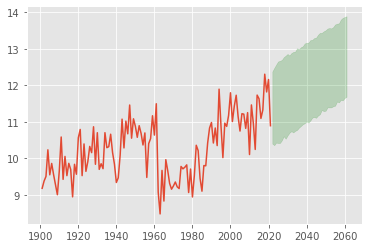

In [65]:
nb_simulation = 1000
delta_simulation = 40
mean_simulation = np.zeros(shape=(nb_simulation,delta_simulation))
last_year = 2021

# Simulation of the different forecast
for i in range(nb_simulation):
    mean_simulation[i,:] = forecast(data_Y, delta_simulation, param, last_year)
# Confidence interval computed

CI_forecast = np.zeros(shape=(delta_simulation,2))
CI_mean = np.zeros(shape=(delta_simulation,2))
CI_std = np.zeros(shape=(delta_simulation,2))

for i in range(delta_simulation):
    CI_mean[i:,] = sc.stats.bootstrap((mean_simulation[:,i],),np.mean, confidence_level=0.95).confidence_interval
    CI_std[i:,] = sc.stats.bootstrap((mean_simulation[:,i],),np.std, confidence_level=0.95).confidence_interval
    CI_forecast[i,:] = sc.stats.norm.interval(0.95,loc=CI_mean[i,:].mean(),scale=CI_std[i,1])
    
fig, ax = plt.subplots()
ax.plot(data_Y.Years,data_Y.Mean)
ax.fill_between(np.arange(2022,2062), CI_forecast[:,0],
                CI_forecast[:,1], alpha=0.2,color='green')

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(data_Y.Years,data_Y.Mean)
ax.fill_between(np.arange(2021,2061), CI_forecast[:,0],
                CI_forecast[:,1], alpha=0.2,color='green')
ax.plot(np.arange(2021,2061),forecast(data_Y, delta_simulation, param, last_year))